In [60]:
from glob import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from enum import Enum
import json
import pandas as pd
import seaborn as sns

# Data Loader

In [122]:
DEPS_SYNTHESIS_PATH = '../experiments/synthesis/deps-synthesis'
PLAIN_SYNTHESIS_PATH = '../experiments/synthesis/skipped-deps-synthesis/'
DEPS_SYNTHESIS_MODEL_CHECKING_PATH = '../experiments/model-checking/deps-synt'

In [62]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    TIMEOUT = "Timeout"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [125]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.hoa"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark with Deps Synthesis" , len(get_all_benchmarks(DEPS_SYNTHESIS_PATH)))
print("Total benchmark with Plain Synthesis" , len(get_all_benchmarks(PLAIN_SYNTHESIS_PATH)))
print("Total benchmark with Deps Synthesis + Model Checking" , len(get_all_benchmarks(DEPS_SYNTHESIS_MODEL_CHECKING_PATH)))

Total benchmark with Deps Synthesis 564
Total benchmark with Plain Synthesis 564
Total benchmark with Deps Synthesis + Model Checking 564


In [66]:
def extract_vars_from_str(x):
    if len(x) == 0:
        return []
    return x.split(",")

In [67]:
def get_benchmark_name(idx):
    path = "../tools/scripts/benchmarks/{}.txt".format(idx)
    with open(path, 'r') as file:
        name = file.readline().replace("\n", "")
    return name
print(get_benchmark_name(2))

EnemeyModule


In [68]:
def benchmark_loader(path: str, idx: str):
    base = {
        'id': idx,
        'Name': get_benchmark_name(idx),
    }
    
    hoa_path = os.path.join(path, idx + ".hoa")
    json_path = os.path.join(path, idx + ".json")
    
    if not os.path.exists(hoa_path):
        return {
            **base,
            'Status': Status.NOT_FOUND
        }

    with open(hoa_path, 'r') as f:
        hoa_content = f.readlines()
        if 'DUE TO TIME LIMIT' in "\n".join(hoa_content):
            return {
                **base,
                'Status': Status.TIMEOUT,
            }

    if not os.path.exists(json_path):
        return {
            **base,
            'Status': Status.ERROR,
            'Error': "\n".join(hoa_content)
        }
    
    with open(json_path, 'r') as f:
        content = "\r\n".join(f.readlines())
        try:
            benchmark_json = json.loads(content)
        except Exception as e:
            return {
                **base,
                'Status': Status.ERROR,
                'Error': content
            }

    # Generic Benchmark Name
    is_completed = benchmark_json['is_completed']
    total_time = benchmark_json['total_time']
    output_vars = benchmark_json['output_vars']
    input_vars = benchmark_json['input_vars']
    is_automaton_built = benchmark_json['automaton']['is_built']
    automaton_build_duration = benchmark_json['automaton'].get('build_duration', None)
    total_states = benchmark_json['automaton'].get('total_states', None)
    total_edges = benchmark_json['automaton'].get('total_edges', None)
    total_output_vars = len(benchmark_json['output_vars'])
    skipped_dependency = benchmark_json['dependency']['skipped_dependencies']

    # Dependency
    find_dependency_duration = benchmark_json['dependency'].get('total_duration', None)
    find_dependency_completed = benchmark_json['dependency']['is_completed']
    total_compatible_pair_states = benchmark_json['dependency'].get('total_pair_state', None)
    find_compatible_pair_states_duration = benchmark_json['dependency'].get('search_pair_state_duration', None)
    dependent_vars = []
    independent_vars = []
    for var_description in benchmark_json["dependency"]['tested_dependencies']:
        if var_description['is_dependent']:
            dependent_vars.append(var_description['name'])
        else:
            independent_vars.append(var_description['name'])
    total_dependent_vars = len(dependent_vars)
    total_independent_vars = len(independent_vars)

    base = {
        **base,
        # Part 1: Benchmark Information
        'Is Completed': is_completed,
        'Total Duration': total_time,
        'Total Output Vars': len(output_vars),
        'Total Input Vars': len(input_vars),
        'Output Vars': output_vars,
        'Input Vars': input_vars,
        'Is Automaton Built': is_automaton_built,
        'Automaton Build Duration': automaton_build_duration,

        # Group 2: Automaton
        'Automaton Total States': total_states,
        'Automaton Total Edges': total_edges,

        # Part 3: Dependency
        'Applied Dependency': not skipped_dependency,
        'Total Dependent Variables': total_dependent_vars,
        'Total Independent Variables': total_independent_vars,
        'Dependent Vars': dependent_vars,
        'Independent Vars': independent_vars,
        'Dependency Ratio': total_dependent_vars / total_output_vars,
        'Find Dependency Duration': find_dependency_duration,
        'Find Dependency Completed': find_dependency_completed,
        'Total Compatible Pair States': total_compatible_pair_states,
        'Find Compatible Pair States Duration': find_compatible_pair_states_duration,
    }

    if not is_completed:
        error = None
        status = Status.TIMEOUT
        if "bad_alloc" in "\n".join(hoa_content):
            status = Status.ERROR
            error = 'Out of Memory'
        elif "Error occurred" in "\n".join(hoa_content):
            status = Status.ERROR
            error = hoa_content[1:]

        return {
            **base,
            'Status': status,
            'Error': error,
        }
    
    # Synthesis
    realizability = benchmark_json['synthesis']['independent_strategy']['realizability']
    indeps_synthesis_duration = benchmark_json['synthesis']['independent_strategy']['duration']

    deps_synthesis_duration = benchmark_json['synthesis']['dependent_strategy']['duration']
    deps_synthesis_duration = deps_synthesis_duration if deps_synthesis_duration != -1 else 0

    model_checking_status = benchmark_json['synthesis']['model_checking_status']

    synthesis_duration = indeps_synthesis_duration
    if total_dependent_vars > 0:
        synthesis_duration += deps_synthesis_duration

    return {
        **base,
        'Status': Status.SUCCESS,

        # Group 4: Synthesis
        'Realizability': realizability,
        'Independent Synthesis Duration': indeps_synthesis_duration,
        'Dependent Synthesis Duration': deps_synthesis_duration,
        'Synthesis Duration': synthesis_duration,
        'Model Checking Status': model_checking_status
    }

In [73]:
def sort_df_order(df):
    columns_by_order = [
        # Group 1: Benchmark Information
        'id',
        'Name',
        'Status',
        'Is Completed',
        'Error',
        'Total Output Vars',
        'Total Input Vars',
        'Output Vars',
        'Input Vars',

        # Group 2: General Performance
        'Total Duration',
        'Is Automaton Built',
        'Automaton Build Duration',
        'Automaton Total States',
        'Automaton Total Edges',

        # Group 3: Dependency
        'Applied Dependency',
        'Total Dependent Variables',
        'Total Independent Variables',
        'Dependent Vars',
        'Independent Vars',
        'Dependency Ratio',
        'Find Dependency Duration',
        'Find Dependency Completed',
        'Total Compatible Pair States',
        'Find Compatible Pair States Duration',

        # Group 4: Synthesis
        'Realizability',
        'Synthesis Duration',
        'Independent Synthesis Duration',
        'Dependent Synthesis Duration',
        'Model Checking Status',
    ]
    return df[columns_by_order]

In [110]:
def load_benchmarks_df(directory_path):
    all_df = pd.DataFrame([
        benchmark_loader(directory_path, name)
        for name in get_all_benchmarks(directory_path)
    ])
    all_df.sort_values(by=['Name'], ascending=True, inplace=True)
    all_df = sort_df_order(all_df)
    all_df.set_index("id", inplace=True)
    return all_df


# Dependency Synthesis

In [114]:
dependents_synthesis_df = load_benchmarks_df(DEPS_SYNTHESIS_PATH)
dependents_synthesis_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Success,True,NaN,3.0,4.0,"[y2, y1, y0]","[x3, x2, x1, x0]",10.0,True,...,0.000000,0.0,True,55.0,0.0,REALIZABLE,2.0,2.0,0.0,UNKNOWN
482,02,Success,True,NaN,4.0,4.0,"[y3, y2, y1, y0]","[x3, x2, x1, x0]",89.0,True,...,0.000000,2.0,True,572.0,2.0,REALIZABLE,52.0,52.0,0.0,UNKNOWN
481,03,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",2385.0,True,...,0.000000,67.0,True,5371.0,67.0,REALIZABLE,2225.0,2225.0,0.0,UNKNOWN
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899986.0,True,...,0.000000,6001.0,False,8344.0,6001.0,NaN,NaN,NaN,NaN,NaN
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",140.0,True,...,0.500000,0.0,True,13.0,0.0,REALIZABLE,1.0,1.0,0.0,UNKNOWN
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",185.0,True,...,0.500000,0.0,True,9.0,0.0,REALIZABLE,1.0,1.0,0.0,UNKNOWN
290,tmp_13cfc6f2,Success,True,NaN,7.0,6.0,"[u0shutter26ctrl0f1ddo26stop1b, u0shutter26ctr...","[p0p0is26open0shutter26input, p0p0is26closed0s...",574.0,True,...,0.285714,45.0,True,382.0,3.0,REALIZABLE,148.0,142.0,6.0,UNKNOWN


In [115]:
dependents_synthesis_df[dependents_synthesis_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899986.0,True,...,0.000000,6001.0,False,8344.0,6001.0,NaN,NaN,NaN,NaN,NaN
272,Alarm_06e9cad4,Timeout,False,None,6.0,14.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,899992.0,True,...,0.333333,34.0,True,531.0,3.0,NaN,NaN,NaN,NaN,NaN
346,Alarm_68c86764,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899992.0,True,...,0.333333,39.0,True,435.0,3.0,NaN,NaN,NaN,NaN,NaN
319,Alarm_70523fbe,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899989.0,True,...,0.333333,33.0,True,379.0,3.0,NaN,NaN,NaN,NaN,NaN
197,Alarm_a5f99bc6,Timeout,False,None,6.0,14.0,"[u0alarm29control0f1dturn2off1b, u0alarm29cont...","[p0p0between0t29pm70t29pm8, p0p0between0t29am5...",899993.0,True,...,0.333333,45.0,True,407.0,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,generalized_buffer,Timeout,False,None,4.0,4.0,"[b2r_req_0, b2r_req_1, b2s_ack_0, b2s_ack_1]","[r2b_ack_0, r2b_ack_1, s2b_req_0, s2b_req_1]",899992.0,True,...,0.000000,6011.0,False,93237.0,6011.0,NaN,NaN,NaN,NaN,NaN
254,jarvis_philippe_484face8,Timeout,False,None,48.0,33.0,"[u0cleaning2robot0f1dclean1b, u0cleaning2robot...","[p0p0lt0temperature0value, p0p0lt0temeprature0...",899975.0,False,...,0.000000,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
504,ltl2dpa22,Timeout,False,None,3.0,6.0,"[p2, p1, p0]","[b, a5, a4, a3, a2, a1]",899993.0,True,...,0.333333,17.0,True,1204.0,7.0,NaN,NaN,NaN,NaN,NaN


In [116]:
dependents_synthesis_df[dependents_synthesis_df['Status'] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,07,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,08,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,09,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,10,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,11,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,12,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,13,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,lilydemo18,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Spot-Modular

In [119]:
spot_modular_synthesis_df = load_benchmarks_df(PLAIN_SYNTHESIS_PATH)
spot_modular_synthesis_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Success,True,NaN,3.0,4.0,"[y2, y1, y0]","[x3, x2, x1, x0]",8.0,True,...,0.0,-1.0,True,-1.0,NaN,REALIZABLE,2.0,2.0,0.0,UNKNOWN
482,02,Success,True,NaN,4.0,4.0,"[y3, y2, y1, y0]","[x3, x2, x1, x0]",66.0,True,...,0.0,-1.0,True,-1.0,NaN,REALIZABLE,51.0,51.0,0.0,UNKNOWN
481,03,Success,True,NaN,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",2049.0,True,...,0.0,-1.0,False,-1.0,NaN,REALIZABLE,1962.0,1962.0,0.0,UNKNOWN
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899991.0,True,...,0.0,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",3.0,True,...,0.0,-1.0,False,-1.0,NaN,REALIZABLE,1.0,1.0,0.0,UNKNOWN
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",3.0,True,...,0.0,-1.0,False,-1.0,NaN,REALIZABLE,1.0,1.0,0.0,UNKNOWN
290,tmp_13cfc6f2,Success,True,NaN,7.0,6.0,"[u0shutter26ctrl0f1ddo26stop1b, u0shutter26ctr...","[p0p0is26open0shutter26input, p0p0is26closed0s...",224.0,True,...,0.0,-1.0,True,-1.0,NaN,REALIZABLE,201.0,201.0,0.0,UNKNOWN


In [120]:
spot_modular_synthesis_df[spot_modular_synthesis_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
484,05,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",899991.0,True,...,0.0,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
272,Alarm_06e9cad4,Timeout,False,None,6.0,14.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,[p0p02time29between0p1db02time29pm71b02time29p...,899992.0,True,...,0.0,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
346,Alarm_68c86764,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899971.0,True,...,0.0,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
319,Alarm_70523fbe,Timeout,False,None,6.0,11.0,[u02shades29ctrl0f1d2shades29move2to0f1d2shade...,"[p0p02time29between02time29pm702time29pm8, p0p...",899772.0,True,...,0.0,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
197,Alarm_a5f99bc6,Timeout,False,None,6.0,14.0,"[u0alarm29control0f1dturn2off1b, u0alarm29cont...","[p0p0between0t29pm70t29pm8, p0p0between0t29am5...",899928.0,True,...,0.0,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,generalized_buffer,Timeout,False,None,4.0,4.0,"[b2r_req_0, b2r_req_1, b2s_ack_0, b2s_ack_1]","[r2b_ack_0, r2b_ack_1, s2b_req_0, s2b_req_1]",899950.0,True,...,0.0,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
254,jarvis_philippe_484face8,Timeout,False,None,48.0,33.0,"[u0cleaning2robot0f1dclean1b, u0cleaning2robot...","[p0p0lt0temperature0value, p0p0lt0temeprature0...",899992.0,False,...,0.0,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
504,ltl2dpa22,Timeout,False,None,3.0,6.0,"[p2, p1, p0]","[b, a5, a4, a3, a2, a1]",899993.0,True,...,0.0,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
spot_modular_synthesis_df[spot_modular_synthesis_df['Status'] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
490,06,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489,07,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,08,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,09,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,10,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,11,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,12,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,13,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,lilydemo18,Error,NaN,Runtime error: Too many acceptance sets used. ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dependency Synthesis (With Model Checking)


In [124]:
deps_synt_model_checking_df = load_benchmarks_df(DEPS_SYNTHESIS_MODEL_CHECKING_PATH)
deps_synt_model_checking_df

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,02,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,03,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,05,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490,06,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",106.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,test_f3987563_1,Success,True,NaN,2.0,2.0,"[u0out0f1db1b, u0out0out]","[p0b0c, p0b0a]",129.0,True,...,0.500000,0.0,True,13.0,0.0,REALIZABLE,1.0,1.0,0.0,OK
426,test_f3987563_2,Success,True,NaN,2.0,2.0,"[u0out250f1dfun0p1db0a1b1b, u0out250out25]","[p0b0c, p0b0a]",112.0,True,...,0.500000,0.0,True,9.0,0.0,REALIZABLE,1.0,1.0,0.0,OK
290,tmp_13cfc6f2,Error,NaN,Hierarchy reader flattened 2 instances of logi...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
deps_synt_model_checking_df[deps_synt_model_checking_df['Status'] == Status.TIMEOUT]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
490,06,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",106.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
489,07,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",104.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
487,08,Timeout,False,None,6.0,5.0,"[y5, y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",129.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
483,09,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",118.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
491,10,Timeout,False,None,5.0,5.0,"[y4, y3, y2, y1, y0]","[x4, x3, x2, x1, x0]",116.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,amba_gr_7,Timeout,False,None,27.0,17.0,"[stateg10_6, stateg10_5, stateg10_4, stateg10_...","[hburst1, hburst0, hlock6, hbusreq6, hlock5, h...",3599995.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
140,amba_gr_8,Timeout,False,None,29.0,19.0,"[stateg10_7, stateg10_6, stateg10_5, stateg10_...","[hburst1, hburst0, hlock7, hbusreq7, hlock6, h...",3599992.0,False,...,0.000000,-1.0,True,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
136,amba_gr_9,Timeout,False,None,32.0,21.0,"[stateg10_8, stateg10_7, stateg10_6, stateg10_...","[hburst1, hburst0, hlock8, hbusreq8, hlock7, h...",3599996.0,False,...,0.000000,-1.0,False,-1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
deps_synt_model_checking_df[deps_synt_model_checking_df['Status'] == Status.ERROR]

,Name,Status,Is Completed,Error,Total Output Vars,Total Input Vars,Output Vars,Input Vars,Total Duration,Is Automaton Built,...,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Total Compatible Pair States,Find Compatible Pair States Duration,Realizability,Synthesis Duration,Independent Synthesis Duration,Dependent Synthesis Duration,Model Checking Status
id,,,,,,,,,,,,,,,,,,,,,
492,01,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,02,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,03,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,05,Error,NaN,srun: error: cn34: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,AllShades_66f450a4,Error,NaN,srun: error: cn40: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,simple_arbiter,Error,NaN,srun: error: cn37: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,simple_arbiter_enc,Error,NaN,srun: error: cn37: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,simple_arbiter_unreal1,Error,NaN,srun: error: cn37: task 0: Segmentation fault\n,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


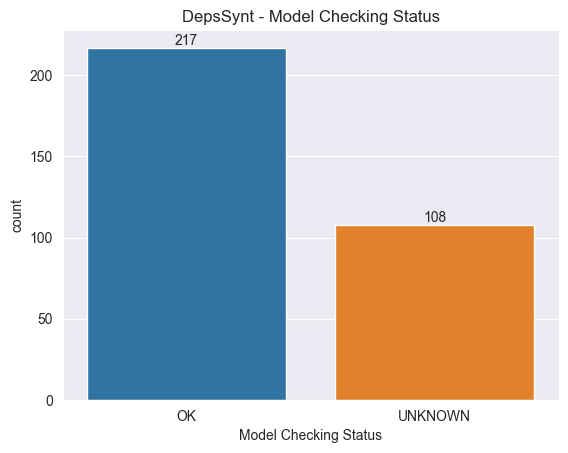

In [129]:
ax = sns.countplot(data=deps_synt_model_checking_df, x='Model Checking Status')
ax.bar_label(ax.containers[0]);
ax.set_title("DepsSynt - Model Checking Status");

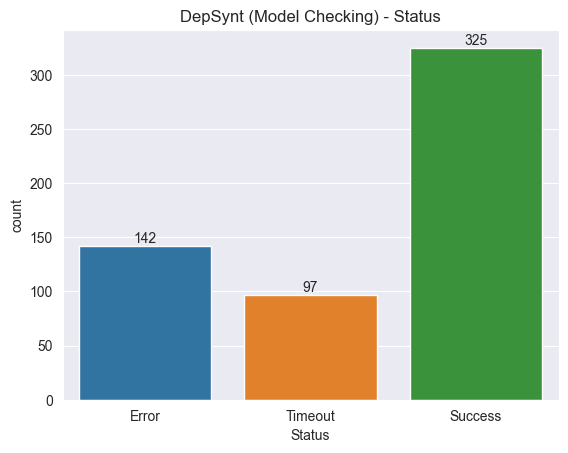

In [131]:
status_df = deps_synt_model_checking_df.copy()
status_df["Status"] = status_df["Status"].astype(str)
ax = sns.countplot(data=status_df, x='Status')
ax.bar_label(ax.containers[0]);
ax.set_title("DepSynt (Model Checking) - Status");

# Summary Results

In [27]:
common_fields = ['Name', 'Status','Is Completed','Total Duration','Realizability','Automaton Build Duration','Synthesis Duration','Error']
dependency_fields = [
    'id',
    'Name',
    'Total Output Vars',
    'Total Dependent Variables',
    'Total Independent Variables',
    'Dependency Ratio',
    'Find Dependency Duration',
    'Find Dependency Completed'
]
synthesis_df = pd.merge(
    plain_synthesis_df[common_fields],
    dependents_synthesis_df[common_fields],
    suffixes=(' (Plain)', ' (Deps)'),
    on='Name',
    how="outer"
)
synthesis_df = pd.merge(
    dependents_synthesis_df[dependency_fields],
    synthesis_df,
    on='Name',
)
synthesis_df.to_csv('./synthesis_summary.csv', index=False)
synthesis_df

,id,Name,Total Output Vars,Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Status (Plain),Is Completed (Plain),...,Automaton Build Duration (Plain),Synthesis Duration (Plain),Error (Plain),Status (Deps),Is Completed (Deps),Total Duration (Deps),Realizability (Deps),Automaton Build Duration (Deps),Synthesis Duration (Deps),Error (Deps)
0,492,01,3.0,0.0,3.0,0.000000,0.0,True,Success,True,...,5.0,2.0,NaN,Success,True,7.0,UNREALIZABLE,4.0,2.0,NaN
1,482,02,4.0,0.0,4.0,0.000000,19.0,True,Success,True,...,15.0,96.0,NaN,Success,True,111.0,UNREALIZABLE,13.0,77.0,NaN
2,481,03,5.0,0.0,5.0,0.000000,1498.0,True,Success,True,...,89.0,4407.0,NaN,Success,True,4888.0,REALIZABLE,80.0,3306.0,NaN
3,484,05,5.0,0.0,5.0,0.000000,799846.0,True,Success,True,...,1060.0,2858404.0,NaN,Success,True,3107125.0,REALIZABLE,889.0,2306374.0,NaN
4,490,06,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,...,NaN,NaN,Runtime error: Too many acceptance sets used. ...,Error,NaN,NaN,NaN,NaN,NaN,Runtime error: Too many acceptance sets used. ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,425,test_f3987563_1,2.0,1.0,1.0,0.500000,0.0,True,Success,True,...,2.0,2.0,NaN,Success,True,3.0,UNREALIZABLE,0.0,0.0,NaN
560,426,test_f3987563_2,2.0,1.0,1.0,0.500000,0.0,True,Success,True,...,1.0,2.0,NaN,Success,True,3.0,UNREALIZABLE,1.0,0.0,NaN
561,290,tmp_13cfc6f2,7.0,2.0,5.0,0.285714,16.0,True,Success,True,...,24.0,346.0,NaN,Success,True,339.0,UNREALIZABLE,22.0,297.0,NaN
562,435,tmp_13cfc6f2_1,3.0,1.0,2.0,0.333333,0.0,True,Success,True,...,3.0,2.0,NaN,Success,True,5.0,UNREALIZABLE,2.0,1.0,NaN


# Sanity Checks

## Statuses

Text(0.5, 1.0, 'Statuses in Dependents Synthesis')

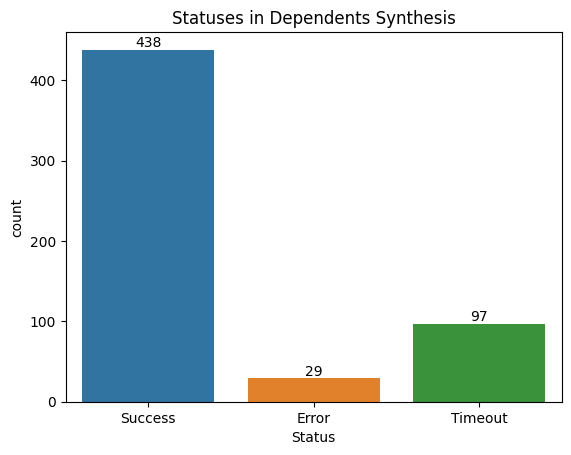

In [15]:
status_df = dependents_synthesis_df.copy()
status_df["Status"] = status_df["Status"].astype(str)
ax = sns.countplot(data=status_df, x='Status')
ax.bar_label(ax.containers[0]);
ax.set_title("Statuses in Dependents Synthesis")

Text(0.5, 1.0, 'Statuses in Spot Hijack Synthesis')

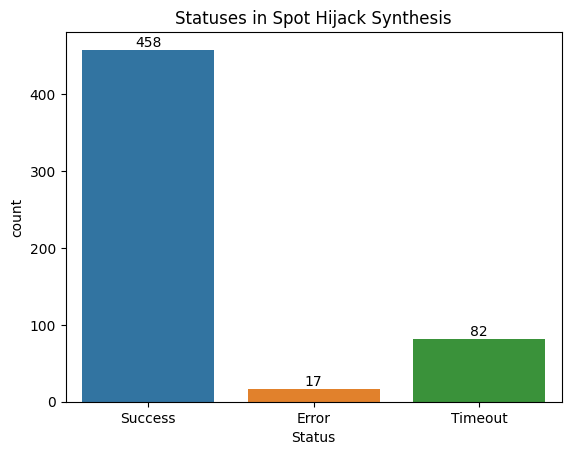

In [16]:
status_df = plain_synthesis_df.copy()
status_df["Status"] = status_df["Status"].astype(str)
ax = sns.countplot(data=status_df, x='Status')
ax.bar_label(ax.containers[0]);
ax.set_title("Statuses in Spot Hijack Synthesis")

## Applied Dependency

In [17]:
fields = ["Applied Unate", "Applied Dependency"]
dependents_synthesis_df[
    ((dependents_synthesis_df["Applied Unate"] != False)
    | (dependents_synthesis_df["Applied Dependency"] != True))
    & (dependents_synthesis_df["Status"] == Status.SUCCESS)
]

,id,Name,Status,Is Completed,Total Duration,Realizability,Applied Unate,Applied Dependency,Independent Strategy Gates,Independent Synthesis Duration,...,Total Positive Unates Vars (At least 1),Total Negative Unates Vars (At least 1),Total Positive Unates Vars (All),Total Negative Unates Vars (All),Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Error


In [18]:
fields = ["Applied Unate", "Applied Dependency"]
plain_synthesis_df[
    ((plain_synthesis_df["Applied Unate"] != False)
    | (plain_synthesis_df["Applied Dependency"] != False))
    & (plain_synthesis_df["Status"] == Status.SUCCESS)
]

,id,Name,Status,Is Completed,Total Duration,Realizability,Applied Unate,Applied Dependency,Independent Strategy Gates,Independent Synthesis Duration,...,Total Positive Unates Vars (At least 1),Total Negative Unates Vars (At least 1),Total Positive Unates Vars (All),Total Negative Unates Vars (All),Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Error


## No Realizability Contradication

In [19]:
realizability_df = pd.merge(
    plain_synthesis_df[["Name", "Realizability"]],
    dependents_synthesis_df[["Name", "Realizability"]],
    suffixes=('_plain', '_dependents'),
    on='Name'
)
realizability_df.head(2)

,Name,Realizability_plain,Realizability_dependents
0,01,UNREALIZABLE,UNREALIZABLE
1,02,UNREALIZABLE,UNREALIZABLE


In [20]:
not_common_realizable = realizability_df[
    ((realizability_df["Realizability_plain"] == "REALIZABLE") & (realizability_df["Realizability_dependents"] != "REALIZABLE")) | 
    ((realizability_df["Realizability_plain"] != "REALIZABLE") & (realizability_df["Realizability_dependents"] == "REALIZABLE"))
]
not_common_realizable

,Name,Realizability_plain,Realizability_dependents
18,Alarm_88c5c1c3,REALIZABLE,NaN
19,Alarm_9cac58d3,REALIZABLE,NaN
42,CheckAlarmBroken1_1a2942e3,REALIZABLE,NaN
45,CheckCoffeMachineBroken1_a5f99bc6,REALIZABLE,NaN
60,CheckWarnlightBroken1_70523fbe,REALIZABLE,NaN
69,CoffeeMin_88f351a6,REALIZABLE,NaN
71,Coffee_235467da,REALIZABLE,NaN
75,Coffee_efe2feaf,REALIZABLE,NaN
120,Example,REALIZABLE,NaN
126,FelixSpecFixed2_fa4d4ce3,REALIZABLE,NaN


## All DataFrame has same order

In [21]:
def verify_name_order(*dataframes):
    for i in range(1, len(dataframes)):
        if not dataframes[i - 1]['Name'].equals(dataframes[i]['Name']):
            return False
    return True

In [22]:
verify_name_order(
    plain_synthesis_df,
    dependents_synthesis_df,
)

False

## Different Statuses

In [23]:
synthesis_df[
    synthesis_df['Status (Plain)'] != synthesis_df['Status (Deps)']
]

,id,Name,Total Output Vars,Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Status (Plain),Is Completed (Plain),Total Duration (Plain),Realizability (Plain),Automaton Build Duration (Plain),Synthesis Duration (Plain),Status (Deps),Is Completed (Deps),Total Duration (Deps),Realizability (Deps),Automaton Build Duration (Deps),Synthesis Duration (Deps)
18,261,Alarm_88c5c1c3,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,3.0,REALIZABLE,1.0,0.0,Error,NaN,NaN,NaN,NaN,NaN
19,335,Alarm_9cac58d3,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,2.0,REALIZABLE,1.0,0.0,Error,NaN,NaN,NaN,NaN,NaN
42,232,CheckAlarmBroken1_1a2942e3,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,1.0,REALIZABLE,0.0,0.0,Error,NaN,NaN,NaN,NaN,NaN
45,333,CheckCoffeMachineBroken1_a5f99bc6,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,11.0,REALIZABLE,3.0,7.0,Error,NaN,NaN,NaN,NaN,NaN
60,203,CheckWarnlightBroken1_70523fbe,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,1.0,REALIZABLE,0.0,0.0,Error,NaN,NaN,NaN,NaN,NaN
69,331,CoffeeMin_88f351a6,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,13.0,REALIZABLE,3.0,8.0,Error,NaN,NaN,NaN,NaN,NaN
71,293,Coffee_235467da,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,507.0,REALIZABLE,9.0,496.0,Error,NaN,NaN,NaN,NaN,NaN
75,228,Coffee_efe2feaf,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,528.0,REALIZABLE,9.0,512.0,Error,NaN,NaN,NaN,NaN,NaN
82,431,Demo1_06e9cad4_1,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN
120,195,Example,NaN,NaN,NaN,NaN,NaN,NaN,Success,True,271673.0,REALIZABLE,1244.0,270343.0,Error,NaN,NaN,NaN,NaN,NaN


# Insights

In [18]:

avg_duration_with_dependents = synthesis_df['Total Duration (Deps)'].mean()
avg_duration_without_dependents = synthesis_df['Total Duration (Plain)'].mean()

print('Average duration with dependents:', avg_duration_with_dependents)
print('Average duration without dependents:', avg_duration_without_dependents)

Average duration with dependents: 14529.202127659575
Average duration without dependents: 20760.909090909092


In [19]:
avg_dependency_ratio = synthesis_df['Dependency Ratio'].mean()
min_dependency_ratio = synthesis_df['Dependency Ratio'].min()
max_dependency_ratio = synthesis_df['Dependency Ratio'].max()
std_dependency_ratio = synthesis_df['Dependency Ratio'].std()

print('Average dependency ratio:', avg_dependency_ratio)
print('Minimum dependency ratio:', min_dependency_ratio)
print('Maximum dependency ratio:', max_dependency_ratio)
print('Standard deviation of dependency ratio:', std_dependency_ratio)


Average dependency ratio: 0.3102549974773066
Minimum dependency ratio: 0.0
Maximum dependency ratio: 1.0
Standard deviation of dependency ratio: 0.2660852171113615


In [20]:
synthesis_df['Synthesis Duration Difference'] = synthesis_df['Total Duration (Deps)'] - synthesis_df['Total Duration (Plain)']
correlation = synthesis_df[['Dependency Ratio', 'Synthesis Duration Difference']].corr().iloc[0, 1]

print('Correlation between dependency ratio and duration difference:', correlation)

Correlation between dependency ratio and duration difference: -0.06711180470639745


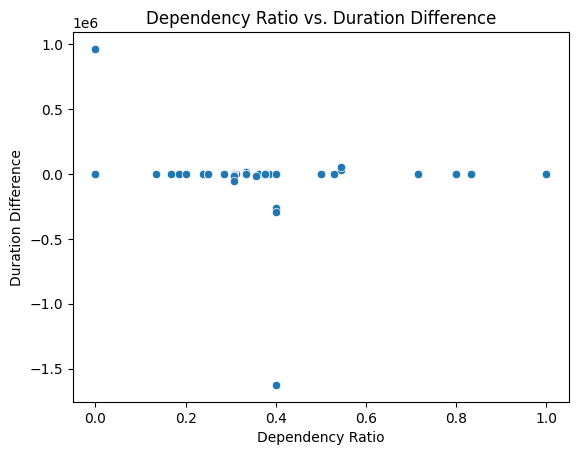

In [21]:
sns.scatterplot(data=synthesis_df, x='Dependency Ratio', y='Synthesis Duration Difference')
plt.title('Dependency Ratio vs. Duration Difference')
plt.xlabel('Dependency Ratio')
plt.ylabel('Duration Difference')
plt.show()


In [22]:
# You can adjust the bin edges according to your data distribution
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['Low', 'Low-Medium', 'Medium-High', 'High']
synthesis_df['Dependency Group'] = pd.cut(synthesis_df['Dependency Ratio'], bins=bins, labels=labels)

grouped_df = synthesis_df.groupby('Dependency Group').agg({
    'Total Duration (Deps)': 'mean',
    'Total Duration (Plain)': 'mean'
})

print(grouped_df)

                  Total Duration (Deps)  Total Duration (Plain)
Dependency Group                                               
Low                          511.300000               24.100000
Low-Medium                  5500.903846            27105.368932
Medium-High                18447.200000              574.200000
High                         385.266667                2.266667


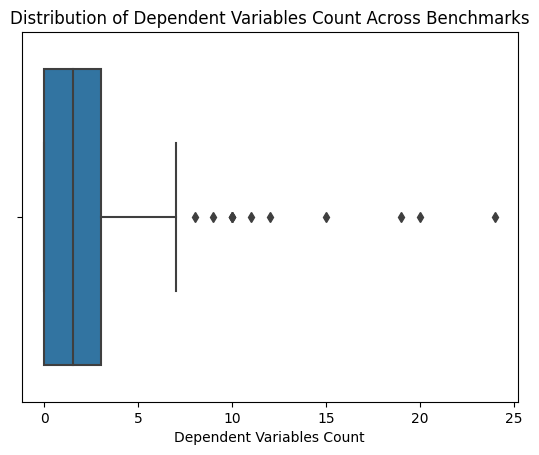

In [23]:
sns.boxplot(data=synthesis_df, x='Total Dependent Variables')
plt.title('Distribution of Dependent Variables Count Across Benchmarks')
plt.xlabel('Dependent Variables Count')
plt.show()


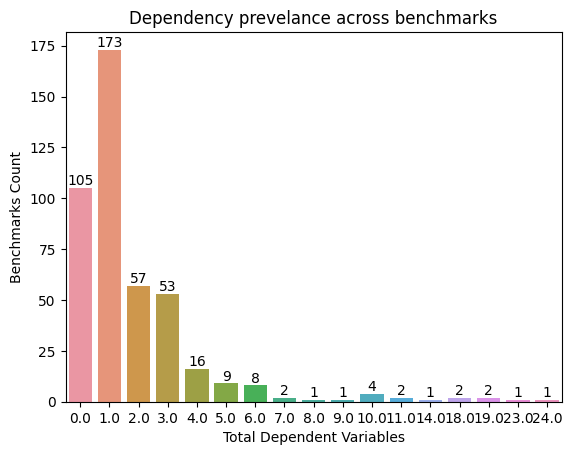

In [24]:
ax = sns.countplot(data=synthesis_df, x='Total Dependent Variables')
ax.bar_label(ax.containers[0]);
ax.set_title('Dependency prevelance across benchmarks');
ax.set_ylabel('Benchmarks Count');

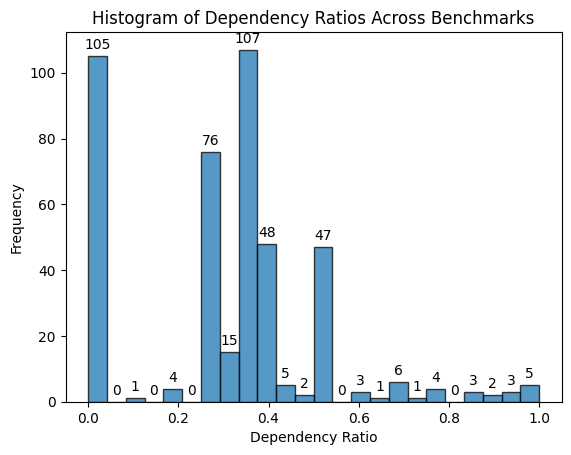

In [28]:
# Assuming your DataFrame is named 'df' and the column with dependency ratio is named 'Dependency Ratio'
fig, ax = plt.subplots()

# Create the histogram using Matplotlib's hist function
df= synthesis_df[synthesis_df["Status (Deps)"] == Status.SUCCESS]
n, bins, patches = ax.hist(df['Dependency Ratio'], bins='auto', edgecolor='black', alpha=0.75)

# Iterate through the patches (bars) and add labels above each bar
for patch in patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    label = f'{int(height)}'
    ax.annotate(label, (x, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Histogram of Dependency Ratios Across Benchmarks')
plt.xlabel('Dependency Ratio')
plt.ylabel('Frequency')
plt.show()
